# Analysis presented in Tables
Here we process information that lead to tables useful for analyze the results.
First, we import all the important packages

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import astropy.units as u
from collections import Counter
import matplotlib.lines as mlines
from scipy.stats import binned_statistic
from astropy.table import Table, join, hstack

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

Additionally, we include some shortcuts to simplify some code

In [3]:
# User shortcuts
def Perc75(array):
    """75th Percentile"""
    return(np.percentile(array, 75))


def Perc25(array):
    """25th Percentile"""
    return(np.percentile(array, 25))


def CreateTableCIG(PaTable, Samp, TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results"""
    for jj in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        MCC = matthews_corrcoef(
            PaTable.loc[jj][Samp], PaTable.loc[jj][TypeAGN])
        F1s = f1_score(PaTable.loc[jj][Samp],
                       PaTable.loc[jj][TypeAGN], average='macro')
        Acc = accuracy_score(PaTable.loc[jj][Samp], PaTable.loc[jj][TypeAGN])
        print(jj, round(MCC, 3), round(F1s, 3), round(Acc, 3))


def CreateTableClas(PaTable, Samp, TypeAGN):
    """Calculate the Matthwes, Cohen, F1-macro and accuracy of the results from the Classifiers"""
    FinalV = []
    for jj in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        X = PaTable.loc[jj][Samp]
        y = PaTable.loc[jj][TypeAGN]
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)
        le = preprocessing.LabelEncoder()
        le.fit(y)
        x_train_encode = preprocessing.robust_scale(x_train)
        x_test_encode = preprocessing.robust_scale(x_test)
        y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
        y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()
        # This classifiers need to be defined before use
        for iclf, Clasi in enumerate([clf_rf, clf_xg]):
            Clasi.fit(x_train_encode, y_train_encode)
            MCC = matthews_corrcoef(
                y_test_encode, Clasi.predict(x_test_encode))
            F1s = f1_score(y_test_encode, Clasi.predict(
                x_test_encode), average='macro')
            Acc = accuracy_score(y_test_encode, Clasi.predict(x_test_encode))
            FinalV.append([['RandomForest', 'XGBoost'][iclf], jj,
                           round(MCC, 3), round(F1s, 3), round(Acc, 3)])
            result = permutation_importance(Clasi, x_test_encode, y_test_encode, n_repeats=20,
                                            random_state=42, n_jobs=-1)
            sorted_idx = result.importances_mean.argsort()
    return array(FinalV)

## Join all clean results

We read the results from the models we are going to use 

In [4]:
ModelS = Table.read('CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

ModelS37 = Table.read('CIGALEOutputs/Cleanresults_SK37.fits', format='fits')
ModelF37 = Table.read('CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We also read the original database of galaxies to use the information for the classification

In [5]:
TV = Table.read('VCV_TAP_otype.txt', format='ascii')
TV.rename_column('main_id', 'id')  # Renamed to use the join with the same id

We join these clean tables with the catalog. We send all the tables to pandas format. Then, we concatenate the tables to have an unique table.

In [6]:
SPandas = join(TV, ModelS, keys='id').to_pandas()
FPandas = join(TV, ModelF, keys='id').to_pandas()
SPandas37 = join(TV, ModelS37, keys='id').to_pandas()
FPandas37 = join(TV, ModelF37, keys='id').to_pandas()
SFPandas = pd.concat([SPandas, FPandas, SPandas37, FPandas37], keys=[
                     'SKIRTOR', 'Fritz', 'S37', 'F37'], names=['Model', 'idCIG'])

## Correlation score with the inclination angles 

We define some selection defitions to be used for the classification task

In [7]:
def SelT1T2SMB(TableP):
    """Select Seyfert 1 and 2 types from CDS"""
    SelcSey = np.logical_or(
        TableP['otype_txt'] == 'Sy1', TableP['otype_txt'] == 'Sy2')
    return(TableP[SelcSey])


def SelT1T2VCV(TableP):
    """Select Seyfert 1 and 2 types from VCV"""
    SelcSey = np.logical_or(TableP['Sp'] == 'S1', TableP['Sp'] == 'S2')
    return(TableP[SelcSey])


def SelT1orT2(TableP):
    """Select Seyferts 1 and 2 in both VCV and CDS"""
    Selc1 = np.logical_and(TableP['otype_txt'] == 'Sy1', TableP['Sp'] == 'S1')
    Selc2 = np.logical_and(TableP['otype_txt'] == 'Sy2', TableP['Sp'] == 'S2')
    SelcSey = np.logical_or(Selc1, Selc2)
    return(TableP[SelcSey])


def SelT1xorT2(TableP):
    """Select mixed classifications Seyferts 1 and 2 between VCV and CDS"""
    Selc1 = np.logical_and(TableP['otype_txt'] == 'Sy1', TableP['Sp'] == 'S2')
    Selc2 = np.logical_and(TableP['otype_txt'] == 'Sy2', TableP['Sp'] == 'S1')
    SelcSey = np.logical_or(Selc1, Selc2)
    return(TableP[SelcSey])


def SelT1orT2VCV(TableP):
    """Select numeric Seyfert types in VCV"""
    Selc1 = np.logical_and(TableP['otype_txt'] ==
                           'Sy1', TableP['Sp'] == 'S1.0')
    Selc2 = np.logical_and(TableP['otype_txt'] ==
                           'Sy1', TableP['Sp'] == 'S1.2')
    Selc3 = np.logical_and(TableP['otype_txt'] ==
                           'Sy1', TableP['Sp'] == 'S1.5')
    Selc4 = np.logical_and(TableP['otype_txt'] ==
                           'Sy2', TableP['Sp'] == 'S1.8')
    Selc5 = np.logical_and(TableP['otype_txt'] ==
                           'Sy2', TableP['Sp'] == 'S1.9')
    SelcSey = np.logical_or.reduce([Selc1, Selc2, Selc3, Selc4, Selc5])
    return(TableP[SelcSey])


def SelT1norT2(TableP):
    """Select all other types in VCV"""
    ISelc = np.logical_and.reduce([TableP['Sp'] != 'S1', TableP['Sp'] != 'S2', 
                                   TableP['Sp'] != 'S1.0', TableP['Sp'] != 'S1.2',
                                   TableP['Sp'] != 'S1.5', TableP['Sp'] != 'S1.8', 
                                   TableP['Sp'] != 'S1.9'])
    return(TableP[ISelc])

If we assume that the returned CIGALE inclination angle of the AGN is correct, we can classify (flag) galaxies in type 1 or 2. We could also assume that numerical types from VCV are close to the respective type 1 or 2. In addition we also include a flag for the AGN disk luminosity, as it will be useful in the analysis.

In [8]:
SFPandas['TypeAGN_CIG'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i'] < 45, 'TypeAGN_CIG'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.i'] >= 45, 'TypeAGN_CIG'] = 'Sy2'
SFPandas['TypeAGN_CIG2'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.i'] < 45, 'TypeAGN_CIG2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.i'] >= 45, 'TypeAGN_CIG2'] = 'S2'
SFPandas['TypeAGN_VCV'] = np.empty(len(SFPandas))
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp'] == 'S1.0', SFPandas['Sp'] == 'S1.2']),
             'TypeAGN_VCV'] = 'S1'
SFPandas.loc[np.logical_or.reduce([SFPandas['Sp'] == 'S1.8',
                                   SFPandas['Sp'] == 'S1.9', SFPandas['Sp'] == 'S1.5']), 
             'TypeAGN_VCV'] = 'S2'
SFPandas['TypeAGN_CIG_Ldisk'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] > (10**10 * u.solLum).to(u.W).value,
             'TypeAGN_CIG_Ldisk'] = 'Sy1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= (10**10 * u.solLum).to(u.W).value, 
             'TypeAGN_CIG_Ldisk'] = 'Sy2'
SFPandas['TypeAGN_CIG_Ldisk2'] = np.empty(len(SFPandas))
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] > (10**10 * u.solLum).to(u.W).value,
             'TypeAGN_CIG_Ldisk2'] = 'S1'
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= (10**10 * u.solLum).to(u.W).value, 
             'TypeAGN_CIG_Ldisk2'] = 'S2'

##### Part TABLE 4

Here we print the values for the tables we are experimenting with. The first three tables are going to be used to create part of Table 4.

In [9]:
CreateTableCIG(SelT1T2SMB(SFPandas), 'otype_txt', 'TypeAGN_CIG')

SKIRTOR 0.526 0.754 0.818
Fritz 0.467 0.721 0.791
S37 0.566 0.774 0.836
F37 0.509 0.733 0.799


In [10]:
CreateTableCIG(SelT1T2VCV(SFPandas), 'Sp', 'TypeAGN_CIG2')

SKIRTOR 0.549 0.768 0.811
Fritz 0.494 0.738 0.786
S37 0.571 0.776 0.819
F37 0.515 0.736 0.782


In [11]:
# As these are in both samples it does not matter if we use 'otype_txt' or 'Sp'
CreateTableCIG(SelT1orT2(SFPandas), 'otype_txt', 'TypeAGN_CIG')

SKIRTOR 0.567 0.779 0.821
Fritz 0.51 0.748 0.795
S37 0.594 0.79 0.831
F37 0.533 0.748 0.794


In [12]:
CreateTableCIG(SelT1xorT2(SFPandas), 'Sp', 'TypeAGN_CIG2')
CreateTableCIG(SelT1xorT2(SFPandas), 'otype_txt', 'TypeAGN_CIG')

SKIRTOR 0.067 0.399 0.436
Fritz 0.102 0.399 0.433
S37 0.015 0.346 0.369
F37 0.112 0.314 0.319
SKIRTOR -0.067 0.431 0.564
Fritz -0.102 0.418 0.567
S37 -0.015 0.467 0.631
F37 -0.112 0.439 0.681


In [13]:
CreateTableCIG(SelT1orT2VCV(SFPandas), 'TypeAGN_VCV', 'TypeAGN_CIG2')

SKIRTOR 0.214 0.555 0.582
Fritz 0.071 0.523 0.529
S37 0.221 0.538 0.576
F37 0.154 0.547 0.559


Interestingly, when using the split by the AGN disk luminosity we obtain a better constraint

In [14]:
CreateTableCIG(SelT1T2SMB(SFPandas), 'otype_txt', 'TypeAGN_CIG_Ldisk')

SKIRTOR 0.603 0.784 0.832
Fritz 0.525 0.752 0.817
S37 0.592 0.778 0.831
F37 0.526 0.751 0.823


In [15]:
CreateTableCIG(SelT1T2VCV(SFPandas), 'Sp', 'TypeAGN_CIG_Ldisk2')

SKIRTOR 0.602 0.784 0.815
Fritz 0.51 0.746 0.793
S37 0.587 0.776 0.813
F37 0.512 0.745 0.799


In [16]:
# As these are in both samples it does not matter if we use 'otype_txt' or 'Sp'
CreateTableCIG(SelT1orT2(SFPandas), 'otype_txt', 'TypeAGN_CIG_Ldisk')

SKIRTOR 0.627 0.8 0.83
Fritz 0.537 0.762 0.808
S37 0.615 0.794 0.83
F37 0.537 0.761 0.814


## Feature selection
Here, we selected the features to use in the estimations for the analysis and predictions. First, we select the max number of useful features from CIGALE output.

We select the physical parameters in all the models and remove the ones that are not useful for our propose (e.g. constant values).

In [17]:
GoodColumns = [jsd for jsd in SelT1orT2(SFPandas).columns if 'bayes' in jsd]
newdf = SelT1orT2(SFPandas)[GoodColumns]
Descr = newdf.describe()
BadCol = [js for js in newdf.columns if Descr[js]
          ['std'] < 1e-2]  # Removing constant columns
newdf = newdf.drop(BadCol, axis=1)
# Removing calculated errors
BadCol2 = [js for js in newdf.columns if '_err' in js]
newdf = newdf.drop(BadCol2, axis=1)
# Removing young estimations
BadCol3 = [js for js in newdf.columns if '_young' in js]
# Removing old estimations
BadCol4 = [js for js in newdf.columns if '_old' in js]
# Removing estimations with lines
BadCol5 = [js for js in newdf.columns if '_lines' in js]
# Removing universe values, these are dependent of redshift
BadCol6 = [js for js in newdf.columns if 'universe' in js]
# Removing filter in the attenuation module
BadCol7 = [js for js in newdf.columns if 'FUV' in js]
BadCols = concatenate([BadCol3, BadCol4, BadCol5, BadCol6, BadCol7])
newdf = newdf.drop(BadCols, axis=1)
newdf = newdf.dropna(axis='columns')
newdf = newdf[newdf.columns[:-31]]  # Remove the mock photometry

We split the sample of galaxies into train and test sets. Then, we encode and scale the physical parameters. 

In [18]:
X = newdf
y = SelT1orT2(SFPandas)['otype_txt']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
le = preprocessing.LabelEncoder()
le.fit(y)
x_train_encode = preprocessing.robust_scale(x_train)
x_test_encode = preprocessing.robust_scale(x_test)
y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
y_test_encode = le.transform(y_test).reshape(-1, 1).ravel()

Principal Component Analysis (PCA) shows that only a few physical parameters are needed. More than ~6 if we made a cut at 99% on the variance ratio. 

Text(0, 0.5, 'Cumulative explained variance')

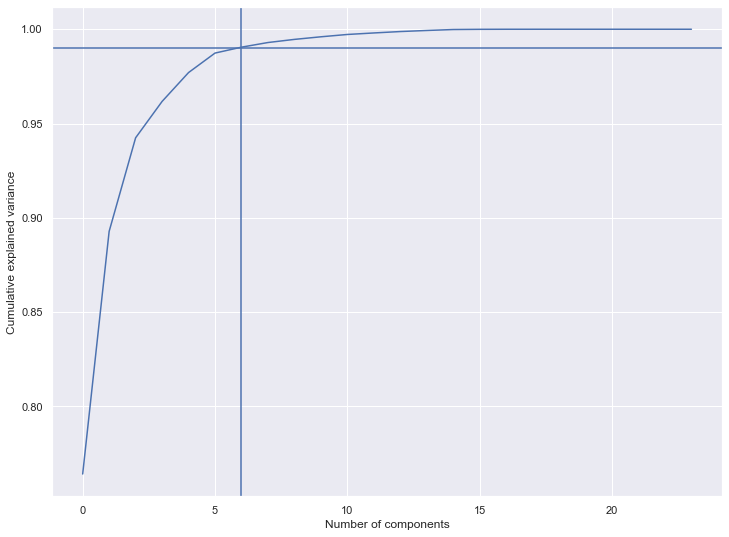

In [19]:
x_train_N = (x_train_encode-x_train_encode.mean()) / \
    (x_train_encode.max()-x_train_encode.min())
# x_test_N = (x_test_encode-x_test_encode.mean())/(x_test_encode.max()-x_test_encode.min())

pca = PCA()
pca.fit(x_train_N)

sns.set()
plt.figure(1, figsize=(12, 9))
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.99)
plt.axvline(x=6)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

As we mentioned in the Pre-Analysis file, we selected two different classifiers (Random Forest and XGBoost). We use the parameters values we found previously (Pre-Analysis file) from the classifiers .

In [20]:
clf_rf = RandomForestClassifier(n_estimators=800, max_depth=35, random_state=42)
clf_xg = xgb.XGBClassifier(n_estimators=400, max_depth=20,
                           random_state=42, use_label_encoder=False, eval_metric='logloss')

We create a feature ranking with recursive feature elimination and cross-validated selection (RFECV). We evaluate with the accuracy score and we use a 5-fold cv. 

In [21]:
rfecv_xg = RFECV(estimator=clf_xg, cv=StratifiedKFold(10), 
                 scoring='accuracy', verbose=4, min_features_to_select=6)
rfecv_xg = rfecv_xg.fit(x_train_encode, y_train_encode)
print('Optimal number of features :', rfecv_xg.n_features_)
print('Best features :', newdf.columns[rfecv_xg.support_])

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 featu

Here the number of correct  classifications is still increasing with the number of features

Text(0, 0.5, 'Correct classifications')

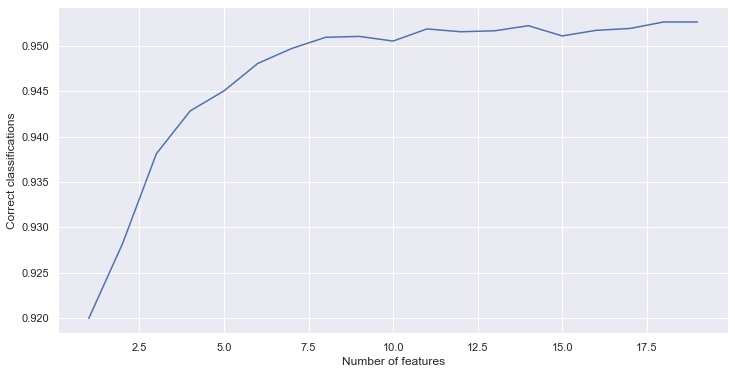

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(rfecv_xg.grid_scores_) + 1),
         rfecv_xg.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Correct classifications')

In [23]:
rfecv_rf = RFECV(estimator=clf_rf, cv=StratifiedKFold(10),
                 scoring='accuracy', min_features_to_select=6, verbose=4, n_jobs=-1)
rfecv_rf = rfecv_rf.fit(x_train_encode, y_train_encode)
print('Optimal number of features :', rfecv_rf.n_features_)
print('Best features :', newdf.columns[rfecv_rf.support_])

Optimal number of features : 24
Best features : Index(['bayes.agn.EBV', 'bayes.agn.fracAGN', 'bayes.agn.i',
       'bayes.attenuation.E_BVs', 'bayes.attenuation.powerlaw_slope',
       'bayes.dust.alpha', 'bayes.sfh.age', 'bayes.sfh.age_main',
       'bayes.sfh.tau_main', 'bayes.stellar.age_m_star',
       'bayes.agn.accretion_power', 'bayes.agn.disk_luminosity',
       'bayes.agn.dust_luminosity', 'bayes.agn.intrin_Lnu_2500A',
       'bayes.agn.luminosity', 'bayes.dust.luminosity', 'bayes.sfh.integrated',
       'bayes.sfh.sfr', 'bayes.sfh.sfr100Myrs', 'bayes.sfh.sfr10Myrs',
       'bayes.stellar.lum', 'bayes.stellar.lum_ly', 'bayes.stellar.m_gas',
       'bayes.stellar.m_star'],
      dtype='object')


Here the number of correct classifications also increasing with the number of features

Text(0, 0.5, 'Correct classifications')

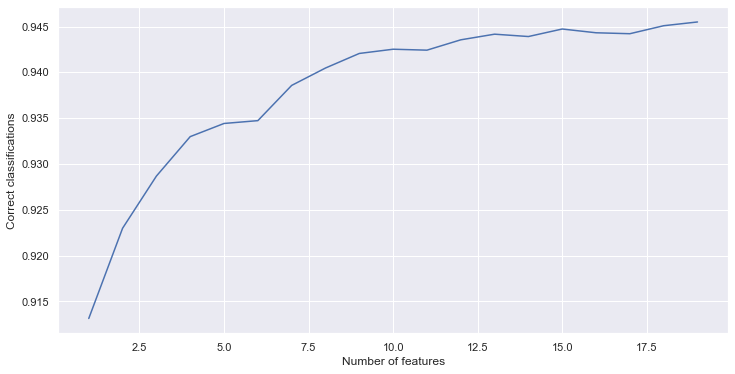

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,len(rfecv_rf.grid_scores_) + 1),
         rfecv_rf.grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Correct classifications')

We can verify the mean feature importance to select the most important physical parameters. 

In [25]:
XGBFI = pd.Series(rfecv_xg.estimator_.feature_importances_,
                  index=newdf.columns[rfecv_xg.support_].array)
RFFI = pd.Series(rfecv_rf.estimator_.feature_importances_,
                 index=newdf.columns[rfecv_rf.support_].array)

This shows there are 2 features that contributes the most (AGN disk luminosity and viewing angle), 3 that contribute a considerable amount (AGN E(B-V), attenuration E(B-V)s and $\tau_{main}$).   

In [26]:
pd.concat([RFFI, XGBFI]).groupby(level=0).mean().sort_values(ascending=False)

bayes.agn.disk_luminosity           0.236537
bayes.agn.i                         0.129710
bayes.attenuation.E_BVs             0.066310
bayes.agn.EBV                       0.059605
bayes.sfh.tau_main                  0.047870
bayes.sfh.sfr                       0.032882
bayes.agn.luminosity                0.031883
bayes.agn.dust_luminosity           0.028138
bayes.dust.alpha                    0.027106
bayes.attenuation.powerlaw_slope    0.026782
bayes.stellar.age_m_star            0.026666
bayes.sfh.integrated                0.026449
bayes.agn.fracAGN                   0.025943
bayes.agn.intrin_Lnu_2500A          0.025782
bayes.sfh.age                       0.024934
bayes.sfh.sfr100Myrs                0.024104
bayes.sfh.age_main                  0.023997
bayes.stellar.m_gas                 0.023395
bayes.dust.luminosity               0.022797
bayes.stellar.m_star                0.022617
bayes.stellar.lum_ly                0.020533
bayes.agn.accretion_power           0.020373
bayes.stel

We decided to select 7 parameters from these list to do the calculations. We include the 5 parameters with a high feature importance (the ones mentioned before) and we add SFR and $f_{AGN}$. These two parameters can give us a better comparison with observational results, and at the same time improve the classification task. 

In [27]:
ManualCols = array(['bayes.agn.i',
                    'bayes.agn.fracAGN',
                    'bayes.agn.disk_luminosity',
                    'bayes.agn.EBV',
                    'bayes.attenuation.E_BVs',
                    'bayes.sfh.sfr',
                    'bayes.sfh.tau_main'])

## Predict classifications with Machine Learning algorithms 
##### Part TABLE 4

We fit the classifiers  with the selected columns. We present the mean feature importance of each of them, together with the same values presented before. 

In [28]:
TABLE4 = CreateTableClas(SelT1orT2(SFPandas), ManualCols, 'otype_txt')

In [29]:
Table(TABLE4).group_by('col0')

col0,col1,col2,col3,col4
str12,str12,str12,str12,str12
RandomForest,SKIRTOR,0.742,0.866,0.895
RandomForest,Fritz,0.712,0.856,0.899
RandomForest,S37,0.749,0.873,0.907
RandomForest,F37,0.738,0.866,0.904
XGBoost,SKIRTOR,0.714,0.854,0.888
XGBoost,Fritz,0.695,0.846,0.89
XGBoost,S37,0.736,0.868,0.906
XGBoost,F37,0.71,0.852,0.895


The <tt> DummyClassifier </tt> was used to check the baseline for the metrics in the predictions when using random configurations. So this can be seem as when the classifier gives bad/none results. 

In [30]:
from sklearn.dummy import DummyClassifier

Dclf = DummyClassifier(strategy='stratified', random_state=42)
# We use all the AGN models, not the train and test samples (It does not matter which one we use)
Dclf.fit(X, y)
DumPred = Dclf.predict(X)

print('DummyClassifier', round(matthews_corrcoef(y, DumPred), 3),
      round(f1_score(y, DumPred, average='macro'), 3), round(accuracy_score(y, DumPred), 3))

DummyClassifier -0.007 0.497 0.635


## Predict the type of Seyfert in unclassified galaxies
Here we select the galaxies with an undefined type (or unknown source) and we predict the type AGN. We compare with just selecting the AGN disk luminosity from CIGALE. As we saw before, the AGN disk luminosity is better in predict the classifications (first part of the TABLE 4). We use a limit at $10^{10}$ solar luminosities, however we prefer leave a gap of 0.5 dex from this value to assure the classification.

In [31]:
SFPandas['CIG_Pred'] = np.empty(len(SFPandas))*np.nan
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] >= (
    10**10.25 * u.solLum).to(u.W).value, 'CIG_Pred'] = 0
SFPandas.loc[SFPandas['bayes.agn.disk_luminosity'] <= (
    10**9.75 * u.solLum).to(u.W).value, 'CIG_Pred'] = 1

We then select two types, one where there is no class associated in VCV and SMB, and another when there is no class in VCV or SMB.

In [32]:
NoClass = SFPandas[np.logical_and(
    SFPandas['otype_txt'] == 'SyG', SFPandas['Sp'] == 'S')]
SemiClass = SFPandas[np.logical_xor(
    SFPandas['otype_txt'] == 'SyG', SFPandas['Sp'] == 'S')]

In [33]:
print('Total number of galaxies without a class in neither VCV and SMB and a good fitting:',
      len(unique(NoClass['id'])))
print('Total number of galaxies without a class in VCV or SMB and a good fitting:',
      len(unique(SemiClass['id'])))

Total number of galaxies without a class in neither VCV and SMB and a good fitting: 16
Total number of galaxies without a class in VCV or SMB and a good fitting: 47


In [34]:
def CreateTableClas(TrainTable, PredTable, Samp, TypeAGN):
    """Precict the type of the unknown Seyferts """
    ColPred1 = []
    ColPred2 = []
    for jj in ['SKIRTOR', 'Fritz', 'S37', 'F37']:
        X = TrainTable.loc[jj][Samp]
        y = TrainTable.loc[jj][TypeAGN]
        XP = PredTable.loc[jj][Samp]
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, random_state=42)
        le = preprocessing.LabelEncoder()
        le.fit(y)
        x_train_encode = preprocessing.robust_scale(x_train)
        y_train_encode = le.transform(y_train).reshape(-1, 1).ravel()
        # These classifiers need to be defined before use
        for iclf, Clasi in enumerate([clf_rf, clf_xg]):
            print(['RF', 'XGB'][iclf], jj)
            Clasi.fit(x_train_encode, y_train_encode)
            XP_encode = preprocessing.robust_scale(XP)
            YP = Clasi.predict(XP_encode)
            if iclf == 0:
                ColPred1 = concatenate((ColPred1, YP), axis=None)
            else:
                ColPred2 = concatenate((ColPred2, YP), axis=None)
    PredTable['RF_Pred'] = ColPred1
    PredTable['XGB_Pred'] = ColPred2
    return(PredTable)

In [35]:
ClassSec = CreateTableClas(SelT1orT2(SFPandas), NoClass, ManualCols, 'otype_txt')
ClassSec2 = CreateTableClas(SelT1orT2(SFPandas), SemiClass, ManualCols, 'otype_txt')

RF SKIRTOR
XGB SKIRTOR
RF Fritz
XGB Fritz
RF S37
XGB S37
RF F37
XGB F37


<ipython-input-34-019bfa3245d4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredTable['RF_Pred'] = ColPred1
<ipython-input-34-019bfa3245d4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredTable['XGB_Pred'] = ColPred2


RF SKIRTOR
XGB SKIRTOR
RF Fritz
XGB Fritz
RF S37
XGB S37
RF F37
XGB F37


<ipython-input-34-019bfa3245d4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredTable['RF_Pred'] = ColPred1
<ipython-input-34-019bfa3245d4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredTable['XGB_Pred'] = ColPred2


In [36]:
TypeTab = Table.from_pandas(ClassSec[['id', 'otype_txt', 'RF_Pred','XGB_Pred',
                                      'CIG_Pred']]).group_by('id').groups.aggregate(np.mean)

/Users/users/ramos/.local/lib/python3.8/site-packages/astropy/table/groups.py:259: UserWarning: Warning: converting a masked element to nan.
  vals = np.array([func(par_col[i0: i1]) for i0, i1 in zip(i0s, i1s)])


In [37]:
TypeTab2 = Table.from_pandas(ClassSec2[['id', 'otype_txt', 'RF_Pred', 'XGB_Pred',
                                        'CIG_Pred']]).group_by('id').groups.aggregate(np.mean)

In [38]:
TypeTab['Mean_clas'] = np.mean([TypeTab['RF_Pred'], TypeTab['XGB_Pred']], axis=0)
TypeTab2['Mean_clas'] = np.mean([TypeTab2['RF_Pred'], TypeTab2['XGB_Pred']], axis=0)

##### TABLE 5

We predict the class depending on the average/mean of all the classifications trained in this work

For the galaxies without any classification we found that 3 would be Sy2, 5 would be Sy1 and the rest (8) are still difficult to classify. 

In [39]:
TypeTab

id,RF_Pred,XGB_Pred,CIG_Pred,Mean_clas
str23,float64,float64,float64,float64
2MASX J12140343-1921428,0.0,0.0,0.0,0.0
2MASX J18121404+2153047,0.0,0.0,1.0,0.0
2MASX J20075080+5938105,1.0,1.0,1.0,1.0
2MASX J21560047-2144325,0.0,0.0,1.0,0.0
2MASX J23032790+1443491,0.0,0.0,1.0,0.0
2XMM J094233.5+470213,0.0,0.0,nan,0.0
2XMM J105045.9+571732,0.0,0.0,1.0,0.0
CADIS 16-505716,0.0,0.0,0.0,0.0
ESO 373-13,1.0,1.0,1.0,1.0


For the galaxies with at least one classification, we found 4 ambiguous cases (2MASS J08171856+5201477, 2MASX J09420770+0228053, 2MASX J10155660-2002268 and 2MASX J22024516-1304538), 7 Seyfert 2 galaxies and the rest (36) are Seyfert 1 galaxies. 

In [40]:
join(TypeTab2[:20],TV['id','Sp','otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,Mean_clas,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
2E 2294,0.0,0.0,0.0,0.0,S1n,SyG
2E 2628,0.0,0.0,0.0,0.0,S1.5,SyG
2E 3786,0.0,0.0,0.0,0.0,S1.0,SyG
2MASS J00423990+3017514,0.0,0.0,0.0,0.0,S1.5,SyG
2MASS J01341936+0146479,0.0,0.0,0.0,0.0,S1.0,SyG
2MASS J02500703+0025251,0.0,0.0,0.0,0.0,S,Sy1
2MASS J08171856+5201477,0.0,0.0,1.0,0.0,S,Sy1
2MASS J09393182+5449092,0.0,0.0,0.0,0.0,S,Sy1
2MASS J09470326+4640425,0.0,0.0,0.0,0.0,S,Sy1


In [41]:
join(TypeTab2[20:40],TV['id','Sp','otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,Mean_clas,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
2MASX J09443702-2633554,0.0,0.0,0.0,0.0,S1.5,SyG
2MASX J09483841+4030436,0.5,0.75,1.0,0.625,S,Sy1
2MASX J10155660-2002268,0.5,0.25,1.0,0.375,S1n,SyG
2MASX J15085291+6814074,0.0,0.25,0.0,0.125,S1.8,SyG
2MASX J16383091-2055246,1.0,0.75,1.0,0.875,S1n,SyG
2MASX J21512498-0757558,1.0,1.0,1.0,1.0,S,Sy1
2MASX J22024516-1304538,0.0,0.0,1.0,0.0,S1.8,SyG
2MASX J23044283-0933454,0.5,1.0,1.0,0.75,S,Sy2
2dFGRS TGN357Z241,0.0,0.0,0.0,0.0,S1.2,SyG


In [42]:
join(TypeTab2[40:],TV['id','Sp','otype_txt'])

id,RF_Pred,XGB_Pred,CIG_Pred,Mean_clas,Sp,otype_txt
str35,float64,float64,float64,float64,str4,str3
ICRF J135704.4+191907,0.0,0.0,0.0,0.0,S1.5,SyG
IRAS 10295-1831,0.25,0.25,nan,0.25,S1.5,SyG
MCG+03-60-031,1.0,1.0,1.0,1.0,S1n,SyG
MCG+05-28-032,0.0,1.0,1.0,0.5,S3,SyG
Mrk 1361,1.0,1.0,1.0,1.0,S,Sy2
PB 162,0.0,0.0,nan,0.0,S,Sy1
UGC 10683,1.0,1.0,1.0,1.0,S1.5,SyG


##### Notebook info

In [43]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
matplotlib: 3.2.2
autopep8  : 1.5.4
seaborn   : 0.10.1
astropy   : 4.2
logging   : 0.5.1.2
pandas    : 1.2.0
json      : 2.0.9
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
re        : 2.2.1
numpy     : 1.19.5
sklearn   : 0.23.1
xgboost   : 1.3.3

Watermark: 2.1.0

